# ML Mini Project: Analysis of Transcriptomics Data

In this project, my task is to predict the disease type from a data set containing the expression levels of 17,970 genes. The disease of interest here is Uterine Corpus Endometrial Carcinoma (UCEC), which is the result of uncontrollable growth of cells that line the uterus<sup>1</sup>. The output labels are binary (1, 0) where 1 encodes the tumor grade II- and 0 encodes the tumor grade III+. I develop a pipeline to test multiple machine learning models such as linear regression, logistic regression, ridge and LASSO regression and select the best model.

In [1]:
%config Completer.use_jedi = False
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

## Loading in the Data and EDA

There are two datasets, CLR and TPM, which only differ in how they are normalized.

* TPM:
    - The gene counts are transformed to transcripts per million, which accounts for gene length and normalizes the reads.

* CLR:
    - The CLR normalized data is the result of a centered log transform on the TPM data.
    
These are two ways of normalizing the dataset. TPM is generally the baseline quantification method for RNA-seq data analysis. CLR has a two additional advantages. First, it normalizes the data such that samples with the same relative abundance are treated as equal. Second, it transforms multiplicative relationships between samples into linear relationships, which allows more accurate modeling of the error<sup>2</sup>. In this project, the effects of each of these normalization methods on model performance will also be compared. 

In [5]:
X_clr = pd.read_csv("UCEC_clr_X.csv", index_col=0)
y_clr = pd.read_csv("UCEC_clr_y.csv", index_col=0)

X_tpm = pd.read_csv("UCEC_tpm_X.csv", index_col=0)
y_tpm = pd.read_csv("UCEC_tpm_y.csv", index_col=0)

In [6]:
#### Checking and confirming that there are no NA's in these data sets ####

print(X_clr.isna().sum().sort_values(ascending=False))
print(y_clr.isna().sum().sort_values(ascending=False))
print(X_tpm.isna().sum().sort_values(ascending=False)) 
print(y_tpm.isna().sum().sort_values(ascending=False))

ENSG00000283697    0
ENSG00000130544    0
ENSG00000130520    0
ENSG00000130522    0
ENSG00000130528    0
                  ..
ENSG00000170458    0
ENSG00000170456    0
ENSG00000170454    0
ENSG00000170448    0
ENSG00000000003    0
Length: 17970, dtype: int64
xml_neoplasm_histologic_grade    0
dtype: int64
ENSG00000283697    0
ENSG00000130544    0
ENSG00000130520    0
ENSG00000130522    0
ENSG00000130528    0
                  ..
ENSG00000170458    0
ENSG00000170456    0
ENSG00000170454    0
ENSG00000170448    0
ENSG00000000003    0
Length: 17970, dtype: int64
xml_neoplasm_histologic_grade    0
dtype: int64


In [7]:
X_clr.shape # X_tpm data has same shape

(554, 17970)

In [8]:
y_clr.shape # y_tpm has same shape

(554, 1)

One of the assumptions of linear and logistic regression is independence between variables. A high degree of multicollinearty violates this assumption, so in order to use linear models, highly correlated variables are removed below.

In [9]:
%%time
#### Removing any highly correlated features ####

import numpy as np

#https://chrisalbon.com/code/machine_learning/feature_selection/drop_highly_correlated_features/
# Create correlation matrix
corr_matrix_clr = X_clr.corr().abs()
corr_matrix_tpm = X_tpm.corr().abs()

# Select upper triangle of correlation matrix
upper_clr = corr_matrix_clr.where(np.triu(np.ones(corr_matrix_clr.shape), k=1).astype(np.bool))
upper_tpm = corr_matrix_tpm.where(np.triu(np.ones(corr_matrix_tpm.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop_clr = [column for column in upper_clr.columns if any(upper_clr[column] > 0.95)]
to_drop_tpm = [column for column in upper_tpm.columns if any(upper_tpm[column] > 0.95)]

# Drop features 
X_clr.drop(to_drop_clr, axis=1, inplace=True)
X_tpm.drop(to_drop_tpm, axis=1, inplace=True)

CPU times: user 11min, sys: 24.7 s, total: 11min 25s
Wall time: 11min 36s


In [10]:
X_clr.shape

(554, 17770)

In [11]:
y_clr.shape

(554, 1)

In [12]:
#### Splitting Data sets: 80-20 Train-test split ####

from sklearn.model_selection import train_test_split

X_clr_train, X_clr_test, y_clr_train, y_clr_test = train_test_split(X_clr, y_clr, test_size=0.2,
                                                                    random_state=2)


X_tpm_train, X_tpm_test, y_tpm_train, y_tpm_test = train_test_split(X_tpm, y_tpm, test_size=0.2,
                                                                   random_state=0)

# Linear and Logistic Regression Without Pipeline and with Default Parameters

## Linear Regression on CLR and TPM Data

In [13]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold


#### Linear Regression on CLR-normalized data ####


## Training the data ##
lin_reg = LinearRegression().fit(X_clr_train, y_clr_train)

## 5-fold CV ##
rkf5 = RepeatedKFold(n_splits=5, n_repeats=5, random_state=19)
cv_score1 = cross_val_score(lin_reg, X_clr, y_clr, cv = rkf5).mean()


## Evaluating model accuracy ##
score = lin_reg.score(X_clr_test, y_clr_test) # this is actually R**2, not accuracy


#### Linear Regression on TPM-normalized data ####

## Training the data ##
lin_reg2 = LinearRegression().fit(X_tpm_train, y_tpm_train)

## 5-fold CV ##
rkf5_2 = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
cv_score2 = cross_val_score(lin_reg2, X_tpm, y_tpm, cv = rkf5_2).mean()   

## Evaluating model accuracy ##
score2 = lin_reg2.score(X_tpm_test, y_tpm_test)

In [14]:
from prettytable import PrettyTable

# Specify the Column Names while initializing the Table 
myTable = PrettyTable(["_", "Linear Regression CLR", "Linear Regression TPM"]) 
  
# Add rows 
myTable.add_row(['5-fold CV score', cv_score1, cv_score2])
myTable.add_row(['R**2', score, score2]) 
print(myTable)

+-----------------+-----------------------+-----------------------+
|        _        | Linear Regression CLR | Linear Regression TPM |
+-----------------+-----------------------+-----------------------+
| 5-fold CV score |  0.46465575886583954  |  -0.5334411160998127  |
|       R**2      |  0.34998078142903266  |  -0.5137961055100502  |
+-----------------+-----------------------+-----------------------+


Running Linear Regression on the data on both the CLR and TPM normalized data yielded unsatisfactory yet unsurprising results.
The models are evaluated using R<sup>2</sup> and using 5-fold cross validation. The 'f1_score' metric results in an error, which may be due to the values in y_clr and y_tpm being binary. The R<sup>2</sup> score using 5-fold cross validation were computed by repeating the 5-fold cross validation step 5 times and taking the average of the resulting accuracy scores. The R<sup>2</sup> scores shown in the table above indicate the performance of the linear regression model. The model performed significantly better on the CLR-normalized data than on the TPM-normalized data; however, neither are very accurate. This is expected because linear regression assumes the target variable is normally distributed, which is not the case for this data as they are binary.

Logistic regression should perform better. 

## Logistic Regression on CLR and TPM Data

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


#### Logistic Regression on CLR-Normalized Data ####


## Training the data ##
logreg1 = LogisticRegression(random_state=0).fit(X_clr_train, y_clr_train)

## Prediction ##
y_pred1 = logreg1.predict(X_clr_test)

## Model Assessment ##
acc_score1 = metrics.accuracy_score(y_clr_test, y_pred1)
f1_score1 = metrics.f1_score(y_clr_test, y_pred1)
prec_score1 = metrics.precision_score(y_clr_test, y_pred1)

## 5-fold Cross Validation ## 
logreg_rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
logreg_cv = cross_val_score(logreg1, X_clr, y_clr, cv = logreg_rkf).mean()



#### Logistic Regression on TPM-normalized data ####


## Training the data ##
logreg2 = LogisticRegression(random_state=0).fit(X_tpm_train, y_tpm_train)

## Prediction ##
y_pred2 = logreg2.predict(X_tpm_test)

## Model Assessment ##
acc_score2 = metrics.accuracy_score(y_tpm_test, y_pred2)
f1_score2 = metrics.accuracy_score(y_tpm_test, y_pred2)
prec_score2 = metrics.precision_score(y_tpm_test, y_pred2)

## 5-fold Cross Validation ## 
logreg_rkf2 = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
logreg_cv2 = cross_val_score(logreg2, X_tpm, y_tpm, cv = logreg_rkf2).mean()

## Logistic Regression Model Evaluation and Comparison to Linear Regression

In [16]:
## Model Evaluation ##
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

myTable2 = PrettyTable(["_", "Logistic RegressionCLR", "Logistic RegressionTPM",
                        "Linear RegressionCLR", "Linear RegressionTPM"]) 
myTable2.add_row(['5-fold CV score', logreg_cv, logreg_cv2, cv_score1, cv_score2])
myTable2.add_row(['Accuracy score', acc_score1, acc_score2, score, score2]) 
myTable2.add_row(['f1 score', f1_score1, f1_score2, "-", "-"])
myTable2.add_row(['Precision score', prec_score1, prec_score2, "-", "-"])
print(myTable2)

+-----------------+------------------------+------------------------+----------------------+----------------------+
|        _        | Logistic RegressionCLR | Logistic RegressionTPM | Linear RegressionCLR | Linear RegressionTPM |
+-----------------+------------------------+------------------------+----------------------+----------------------+
| 5-fold CV score |   0.8443996723996725   |   0.7490974610974611   | 0.46465575886583954  | -0.5334411160998127  |
|  Accuracy score |   0.7927927927927928   |   0.7117117117117117   | 0.34998078142903266  | -0.5137961055100502  |
|     f1 score    |   0.8270676691729324   |   0.7117117117117117   |          -           |          -           |
| Precision score |   0.8088235294117647   |   0.7424242424242424   |          -           |          -           |
+-----------------+------------------------+------------------------+----------------------+----------------------+


As expected, logistic regression performed significantly better than linear regression, likely because linear regression struggles when the target variable is binary/not normally distributed. The model still performed significantly better on the CLR dataset than on the TPM data set. Across both linear and logistic regression models, the results on the CLR dataset are consistently and significantly better than the TPM dataset. Since every subsequent model is a variation of linear or logistic regression, this observation should continue to hold. Because of this, all subsequent models will be run only on the CLR dataset. This will yield the best model and shorten total runtime. 


Next, I use GridSearchCV to improve the model by finding and selecting the optimal parameters. This should yield the best model. A benefit of using GridSearchCV is that it is an easy, built-in method of finding the best combination of parameters, so that the scientist does not have to manually test every combination, which would be very laborious. A disadvantage, however, is that GridSearchCV only operates on the parameters provided to it. So the scientist must have an understanding of the data/problem and the parameters of the model and must make decisions about which parameters to include and which not to include. If everything is included in the model, then GridSearchCV will take a very long time to run. 

For the purposes of this project, the parameters I test are:

* 1: Scaling Method
       - I find the best scaling method of StandardScaler(), MaxAbsScaler(), MinMaxScaler(), and Normalizer().
* 2: C
       - The value of C is the inverse of regularization strength. Regularization effectively shrinks the coefficient estimates towards zero, which 
         prevents learning a complex model and therefore prevents overfitting. So a smaller value C corresponds to stronger regularization.
* 3: Penalty
       - The Penalty parameter determines the method by which a penalty is added to the model. "l1" (LASSO) penalty allows coefficients to shrink to          zero, while "l2" (Ridge) penalty only allows coefficients to approach zero. "elasticnet" is a combination of "l1" and "l2". Of the options          "none" (no penalty), "l1", "l2" and "elasticnet", I find the best penalty. 
         
* 4: Solver
       - The solvers are various algorithms used in this optimization problem. The solvers I am testing are "liblinear", "newton-cg" and "lbfgs"
       
       
Since Logistic regression is significantly better than linear regression for this problem, I only run GridSearchCV on logistic regression.

## Finding Optimal Parameters for Logistic Regression

## Finding Best Scaling method first

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

scaler = StandardScaler()
log_model = LogisticRegression()
pipe1 = Pipeline(steps=[('scaler', scaler),
                       ('logistic', log_model)])

scale_parameters =  {'scaler': [StandardScaler(), MaxAbsScaler(),
                MinMaxScaler(), Normalizer()]
}

scaled_gs = GridSearchCV(pipe1, scale_parameters, verbose=True, cv=5).fit(X_clr_train, y_clr_train)
scaled_log_model = scaled_gs.best_estimator_
scaled_gs.best_params_ # MinMaxScaler() is the best scaling parameter

Fitting 5 folds for each of 4 candidates, totalling 20 fits


{'scaler': MinMaxScaler()}

## Finding Optimal 'C', 'Penalty', and 'Solver' Parameters

In [16]:
%%time
C_val = np.logspace(-4, 4, 20)
Penalty = ['l1', 'l2', 'elastinet', 'none']
Solver = ['lbfgs', 'newton-cg', 'liblinear']

param_list = dict(logistic__penalty = Penalty,
         logistic__C = C_val,
         logistic__solver = Solver)


gs = GridSearchCV(scaled_log_model, param_list, verbose=True, scoring='accuracy')
gs.fit(X_clr_train, y_clr_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
CPU times: user 34min 2s, sys: 4min 30s, total: 38min 33s
Wall time: 13min 42s


GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('logistic', LogisticRegression())]),
             param_grid={'logistic__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'logistic__penalty': ['l1', 'l2', 'elastinet', 'none'],
                         'logistic__solver': ['lbfgs', 'newton-cg',
                                              'liblinear']},
             scoring='accuracy', verbose=True)

In [17]:
print(gs.best_params_)
print()
print(gs.best_estimator_)

{'logistic__C': 0.23357214690901212, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logistic', LogisticRegression(C=0.23357214690901212))])


## Logistic Regression using Optimal Parameters

In [18]:
best_model = gs.best_estimator_
best_y_pred = best_model.predict(X_clr_test)

## 5-fold Cross Validation ## 
rkf_best = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
best_cv = cross_val_score(best_model, X_clr, y_clr, cv = rkf_best).mean()

best_model_acc = metrics.accuracy_score(y_clr_test, best_y_pred)
best_model_prec = metrics.precision_score(y_clr_test, best_y_pred)
best_model_f1 = metrics.f1_score(y_clr_test, best_y_pred)

In [19]:
myTable3 = PrettyTable(["_", "Best Logistic Regression CLR", "Default Logistic Regression CLR"]) 
myTable3.add_row(['5-fold CV score', best_cv, logreg_cv])
myTable3.add_row(['Accuracy score', best_model_acc, acc_score1]) 
myTable3.add_row(['f1 score', best_model_f1, f1_score1])
myTable3.add_row(['Precision score', best_model_prec, prec_score1])
print(myTable3)

+-----------------+------------------------------+---------------------------------+
|        _        | Best Logistic Regression CLR | Default Logistic Regression CLR |
+-----------------+------------------------------+---------------------------------+
| 5-fold CV score |      0.8444127764127763      |        0.8443996723996725       |
|  Accuracy score |      0.8018018018018018      |        0.7927927927927928       |
|     f1 score    |      0.835820895522388       |        0.8270676691729324       |
| Precision score |      0.8115942028985508      |        0.8088235294117647       |
+-----------------+------------------------------+---------------------------------+


The results of the GridSearchCV on logistic regression are that the optimal parameters are:

* scaler: MinMaxScaler()

* C: 0.23357214690901212

* penalty: l2

* solver: lbfgs

The table above shows that the best logistic regression model is only slightly better than the default logistic regression. The "l2" penalty and "lbfgs" solver, which are the optimal penalty and solver, respectively, are also the default for logistic regression. The default C value is 1.0, the improvement likely came from stronger regularization, shown by the smaller C value of 0.23357214690901212. 

# Using Pipelines to Test Different Linear Models

## Ridge Regression Classifier using Optimal 'alpha' Parameter

In [20]:
from sklearn.linear_model import RidgeClassifier

scaler = StandardScaler()
rc = RidgeClassifier()
pipe_ridgeClass = Pipeline(steps=[('scale', scaler),
                       ('estimator', rc)])

alpha = np.arange(0, 1, 0.5)

alpha_param = dict(estimator__alpha = alpha)

cv5_ridge = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
ridge_gs = GridSearchCV(pipe_ridgeClass, alpha_param, cv= cv5_ridge).fit(X_clr, y_clr)
ridge_gs.best_params_ # best alpha is alpha = 0.0

best_ridgeClass = ridge_gs.best_estimator_
best_ridgeClass = best_ridgeClass.fit(X_clr_train, y_clr_train)
best_ridge_pred = best_ridgeClass.predict(X_clr_test)

## 5-fold Cross Validation ## 
rkf_ridge = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
best_ridge_cv = cross_val_score(best_ridgeClass, X_clr, y_clr, cv = rkf_ridge).mean()

best_ridge_acc = metrics.accuracy_score(y_clr_test, best_ridge_pred)
best_ridge_prec = metrics.precision_score(y_clr_test, best_ridge_pred)
best_ridge_f1 = metrics.f1_score(y_clr_test, best_ridge_pred)

In [21]:
myTable4 = PrettyTable(["_", "Best Ridge Classifier", "Best Logistic Regression CLR", 
                        "Default Logistic Regression CLR"]) 
myTable4.add_row(['5-fold CV score', best_ridge_cv, best_cv, logreg_cv])
myTable4.add_row(['Accuracy score', best_ridge_acc, best_model_acc, acc_score1]) 
myTable4.add_row(['f1 score', best_ridge_f1, best_model_f1, f1_score1])
myTable4.add_row(['Precision score', best_ridge_prec, best_model_prec, prec_score1])
print(myTable4)

+-----------------+-----------------------+------------------------------+---------------------------------+
|        _        | Best Ridge Classifier | Best Logistic Regression CLR | Default Logistic Regression CLR |
+-----------------+-----------------------+------------------------------+---------------------------------+
| 5-fold CV score |   0.8483701883701884  |      0.8444127764127763      |        0.8443996723996725       |
|  Accuracy score |   0.7837837837837838  |      0.8018018018018018      |        0.7927927927927928       |
|     f1 score    |   0.8153846153846154  |      0.835820895522388       |        0.8270676691729324       |
| Precision score |   0.8153846153846154  |      0.8115942028985508      |        0.8088235294117647       |
+-----------------+-----------------------+------------------------------+---------------------------------+


## LASSO Regression with Optimal 'alpha' Parameter

In [22]:
from sklearn.linear_model import Lasso

scaler = MinMaxScaler()
lasso = Lasso()
pipe_lasso = Pipeline(steps=[('scale', scaler),
                       ('estimator', lasso)])

lasso_alpha = np.arange(1, 100, 10)

lasso_param = dict(estimator__alpha = lasso_alpha)

cv5_lasso = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
lasso_gs = GridSearchCV(pipe_lasso, lasso_param, cv= cv5_lasso).fit(X_clr, y_clr)
lasso_gs.best_params_ # best alpha is alpha = 0.0

best_lasso = lasso_gs.best_estimator_
best_lasso = best_lasso.fit(X_clr_train, y_clr_train)
best_lasso_pred = best_lasso.predict(X_clr_test)

## Accuracy score ##
best_lasso_score = best_lasso.score(X_clr_test, y_clr_test)

## 5-fold Cross Validation ## 
rkf_lasso = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
best_lasso_cv = cross_val_score(best_lasso, X_clr, y_clr, cv = rkf_lasso).mean()

In [23]:
myTable5 = PrettyTable(["_", "Best Ridge", "Best Logistic", 
                        "Default Logistic", "Best Lasso"]) 
myTable5.add_row(['5-fold CV score', best_ridge_cv, best_cv, logreg_cv, best_lasso_cv])
myTable5.add_row(['Accuracy score', best_ridge_acc, best_model_acc, acc_score1, best_lasso_score]) 
myTable5.add_row(['f1 score', best_ridge_f1, best_model_f1, f1_score1, "-"])
myTable5.add_row(['Precision score', best_ridge_prec, best_model_prec, prec_score1, "-"])
print(myTable5)

+-----------------+--------------------+--------------------+--------------------+-------------------------+
|        _        |     Best Ridge     |   Best Logistic    |  Default Logistic  |        Best Lasso       |
+-----------------+--------------------+--------------------+--------------------+-------------------------+
| 5-fold CV score | 0.8483701883701884 | 0.8444127764127763 | 0.8443996723996725 |  -0.015049738540661899  |
|  Accuracy score | 0.7837837837837838 | 0.8018018018018018 | 0.7927927927927928 | -3.6060938279902643e-06 |
|     f1 score    | 0.8153846153846154 | 0.835820895522388  | 0.8270676691729324 |            -            |
| Precision score | 0.8153846153846154 | 0.8115942028985508 | 0.8088235294117647 |            -            |
+-----------------+--------------------+--------------------+--------------------+-------------------------+


Ridge Regrerssion (classifier) and LASSO regression are also compared to the best logistic regression model. The best performing model is the logistic regression using the parameters: 'C': 0.23357214690901212, 
'penalty': l2, 'solver': lbfgs. This model outperformed Ridge classifier regression, default logistic 
regression and lasso.

## Comparison of Best Logistic Regression Model with Dummy Model

In [24]:
from sklearn.dummy import DummyClassifier


dummy_class = DummyClassifier(strategy= 'uniform', random_state=0).fit(X_clr_train, y_clr_train)
dummy_y_pred = dummy_class.predict(X_clr_test)

## 5-fold Cross Validation ## 
rkf_dummy = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
best_dummy_cv = cross_val_score(dummy_class, X_clr, y_clr, cv = rkf_dummy).mean()

best_dummy_acc = metrics.accuracy_score(y_clr_test, dummy_y_pred)
best_dummy_prec = metrics.precision_score(y_clr_test, dummy_y_pred)
best_dummy_f1 = metrics.f1_score(y_clr_test, dummy_y_pred)

+-----------------+--------------------+--------------------+
|        _        |   Best Logistic    |  Dummy Classifier  |
+-----------------+--------------------+--------------------+
| 5-fold CV score | 0.8444127764127763 | 0.5147846027846028 |
|  Accuracy score | 0.8018018018018018 | 0.5855855855855856 |
|     f1 score    | 0.835820895522388  | 0.634920634920635  |
| Precision score | 0.8115942028985508 | 0.6557377049180327 |
+-----------------+--------------------+--------------------+


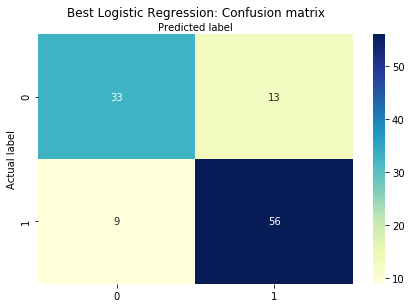

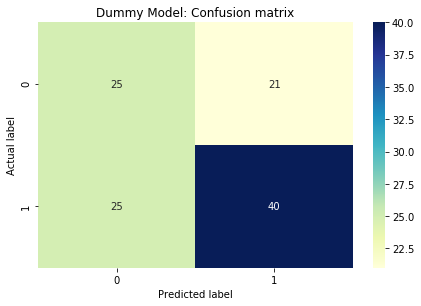

In [25]:
myTable6 = PrettyTable(["_", "Best Logistic", "Dummy Classifier"]) 
myTable6.add_row(['5-fold CV score', best_cv, best_dummy_cv])
myTable6.add_row(['Accuracy score', best_model_acc, best_dummy_acc]) 
myTable6.add_row(['f1 score', best_model_f1, best_dummy_f1])
myTable6.add_row(['Precision score', best_model_prec, best_dummy_prec])
print(myTable6)


## Best Logistic Regression Model ##
cnf_matrix = metrics.confusion_matrix(y_clr_test, best_y_pred)

# Generating Confusion matrix Heatmap
class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Best Logistic Regression: Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


## Dummy Model ##
cnf_matrix2 = metrics.confusion_matrix(y_clr_test, dummy_y_pred)

# Generating Confusion matrix Heatmap
class_names2=[0,1] 
fig2, ax2 = plt.subplots()
tick_marks2 = np.arange(len(class_names))
plt.xticks(tick_marks2, class_names2)
plt.yticks(tick_marks2, class_names2)
sns.heatmap(pd.DataFrame(cnf_matrix2), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Dummy Model: Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

My best logistic regression model is further evaluated by comparing it to a dummy model (random guessing), and it outperformed the dummy model by around 20%. 

Now that I have my best model, I use this model to identify the genes that are most important for whether a tumor is grade II- or III+.

# Assessing Feature Importance

In [26]:
importance = best_model[-1].coef_[0]
feature = pd.DataFrame(importance)
feature = feature.rename(columns={0: "Importance"})
feature = feature.sort_values(by=["Importance"], ascending=False) # most positive

## Top 5 Genes that Predict Tumor Grade "II-" (Class 1)

In [27]:
top_5_pos = X_clr.iloc[:, [838, 10629, 13188, 15883, 17037]]
# positive predicts class 1, which is Tumor grade "II-"

myTable7 = PrettyTable(["ENSMBL ID", "Gene", 'Description']) 
myTable7.add_row(['ENSG00000064218', 'DMRT3', 'Spinal cord circuits, neuronal differentiation'])
myTable7.add_row(['ENSG00000164532', 'TBX20', 'Cardiac Development']) 
myTable7.add_row(['ENSG00000177947', 'ODF3', 'Sperm tail'])
myTable7.add_row(['ENSG00000204193', 'TXNDC8', 'Post-translational modifications for proteins required for acrosomal biogenesis'])
myTable7.add_row(['ENSG00000241598', 'KRTAP5-4', '?'])
print(myTable7)

+-----------------+----------+---------------------------------------------------------------------------------+
|    ENSMBL ID    |   Gene   |                                   Description                                   |
+-----------------+----------+---------------------------------------------------------------------------------+
| ENSG00000064218 |  DMRT3   |                  Spinal cord circuits, neuronal differentiation                 |
| ENSG00000164532 |  TBX20   |                               Cardiac Development                               |
| ENSG00000177947 |   ODF3   |                                    Sperm tail                                   |
| ENSG00000204193 |  TXNDC8  | Post-translational modifications for proteins required for acrosomal biogenesis |
| ENSG00000241598 | KRTAP5-4 |                                        ?                                        |
+-----------------+----------+------------------------------------------------------------------

## Top 5 Genes that Predict Tumor Grade "III+" (Class 0)

In [28]:
top_5_neg = X_clr.iloc[:, [16184, 11432, 9166, 3694, 17352]]
# negative predics class 0, which is Tumor grrade "III+"

myTable8 = PrettyTable(["ENSMBL ID", "Gene", 'Description']) 
myTable8.add_row(['ENSG00000206013', 'IFITM5', 'Normal bone mineralization'])
myTable8.add_row(['ENSG00000168148', 'H3-4', 'DNA repair, replication, chromosome stability']) 
myTable8.add_row(['ENSG00000154165', 'GPR15', 'Probable chemokine receptor'])
myTable8.add_row(['ENSG00000111262', 'KCNA1', 'Voltage-gated potassium channel'])
myTable8.add_row(['ENSG00000256436', 'TAS2R31', 'Taste receptor that may play a role in the perception of bitterness'])
print(myTable8)

+-----------------+---------+---------------------------------------------------------------------+
|    ENSMBL ID    |   Gene  |                             Description                             |
+-----------------+---------+---------------------------------------------------------------------+
| ENSG00000206013 |  IFITM5 |                      Normal bone mineralization                     |
| ENSG00000168148 |   H3-4  |            DNA repair, replication, chromosome stability            |
| ENSG00000154165 |  GPR15  |                     Probable chemokine receptor                     |
| ENSG00000111262 |  KCNA1  |                   Voltage-gated potassium channel                   |
| ENSG00000256436 | TAS2R31 | Taste receptor that may play a role in the perception of bitterness |
+-----------------+---------+---------------------------------------------------------------------+


# PCA and Visualization

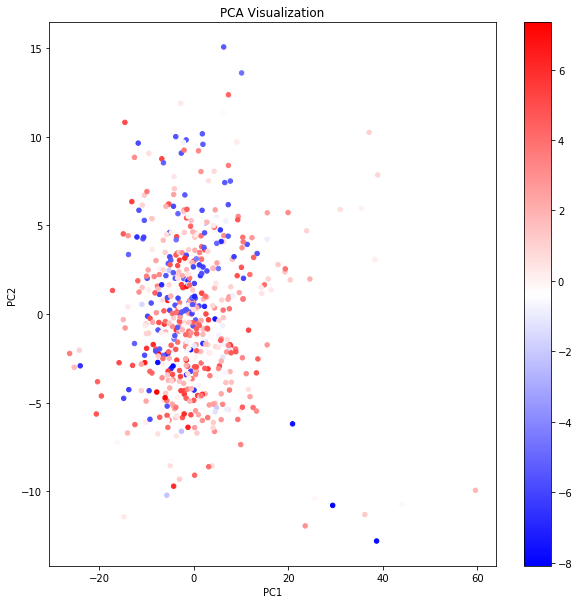

In [29]:
from sklearn.decomposition import PCA

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X_clr)
pca = PCA(0.95)
pca.fit(scaled_X)
PCs = pca.transform(scaled_X)
plt.figure(figsize=(10,10))
plt.scatter(PCs[:,0], PCs[:,1], c = X_clr["ENSG00000064218"], s = 20, cmap='bwr')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("PCA Visualization")
plt.colorbar()
plt.show()

Above are tables that show the most important genes for determining the tumor grade. Several of the genes were somewhat unexpected. Some genes are involved in neural differentiation, cardiac development, bone mineralization. These are not functions that I would have thought were related to uterine endometiral carcinoma, but they very well might be, so these genes and their relationship to this cancer type may be an exciting area of research. 

# References

1: https://www.cancerresearch.org/en-us/immunotherapy/cancer-types/uterine-endometrial-cancer

2: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-020-3427-8
